#### 1. Import Library and Config

In [180]:
from random import shuffle
import h5py
import pandas as pd
import numpy as np
import cv2
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
import config
import glob

In [181]:
conf = config.Config()
r = pd.DataFrame(columns=['Value', 'Energy', 'ParticleType', 'V', 'cm', 'run', 'evNo', 'filename'])

Now we will map every image to its image_id

In [182]:
data_map = []
for sub_dir_path in glob.glob(os.path.join(conf.DATA_DIR_TRAIN , "*")):
    try:
        dir_name = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            if filename.endswith(conf.IMAGE_EXTENSION):
                image_path = os.path.join(sub_dir_path ,filename)
                data_map.extend([filename, image_path])
    except Exception as e:
        print(e)


In [183]:
df = pd.DataFrame({"filename" : data_map[::2],
                   "fullpath" : data_map[1::2]})
df.head()

,filename,fullpath
0,-0.003018522635102272__CYGNO_60_40_ER_30_keV_9...,C:\Users\alexl\Downloads\idao_dataset\train\ER...
1,-0.0031084376387298107__CYGNO_60_40_ER_3_keV_9...,C:\Users\alexl\Downloads\idao_dataset\train\ER...
2,-0.003241758095100522__CYGNO_60_40_ER_3_keV_93...,C:\Users\alexl\Downloads\idao_dataset\train\ER...
3,-0.0032767392694950104__CYGNO_60_40_ER_10_keV_...,C:\Users\alexl\Downloads\idao_dataset\train\ER...
4,-0.004240238573402166__CYGNO_60_40_ER_3_keV_93...,C:\Users\alexl\Downloads\idao_dataset\train\ER...


In [184]:
elements = df["filename"].str.split('_keV_')
r["filename"] =  df["filename"]
r["Value"] = pd.to_numeric(elements.str[0].str.split('_').str[0], errors='coerce')
r["Energy"] = pd.to_numeric(elements.str[0].str.split('_').str[-1], errors='coerce')
r["ParticleType"] = elements.str[0].str.split('_').str[-2]
# All V values are 930
#r["V"] = pd.to_numeric(elements.str[1].str.split('_').str[0].apply(lambda x: x.replace("V", "")) , errors='coerce') 
# All cm values are 30.
# r["cm"] = pd.to_numeric(elements.str[1].str.split('_').str[1].apply(lambda x: x.replace("cm", "")), errors='coerce')
r["run"] = pd.to_numeric(elements.str[1].str.split('_').str[-2].apply(lambda x: x.replace("run", "")), errors='coerce')
r["evNo"] = elements.str[1].str.split('_').str[-1].str.extract(r'ev([0-9]+)')
r["evNo"] = pd.to_numeric(r["evNo"], errors='coerce').astype(np.int64)

In [185]:
r.head(5).append(r.tail(5))

,Value,Energy,ParticleType,V,cm,run,evNo,filename
0,-0.003019,30,ER,NaN,NaN,1,121,-0.003018522635102272__CYGNO_60_40_ER_30_keV_9...
1,-0.003108,3,ER,NaN,NaN,5,860,-0.0031084376387298107__CYGNO_60_40_ER_3_keV_9...
2,-0.003242,3,ER,NaN,NaN,5,346,-0.003241758095100522__CYGNO_60_40_ER_3_keV_93...
3,-0.003277,10,ER,NaN,NaN,1,806,-0.0032767392694950104__CYGNO_60_40_ER_10_keV_...
4,-0.004240,3,ER,NaN,NaN,5,702,-0.004240238573402166__CYGNO_60_40_ER_3_keV_93...
13275,3.138800,1,NR,NaN,NaN,4,948,3.1387999057769775__CYGNO_60_40_He_NR_1_keV_93...
13276,3.140400,20,NR,NaN,NaN,4,768,3.140399932861328__CYGNO_60_40_He_NR_20_keV_93...
13277,3.140800,20,NR,NaN,NaN,4,989,3.1407999992370605__CYGNO_60_40_He_NR_20_keV_9...
13278,3.141300,6,NR,NaN,NaN,5,932,3.1412999629974365__CYGNO_60_40_He_NR_6_keV_93...
13279,3.141400,1,NR,NaN,NaN,5,306,3.141400098800659__CYGNO_60_40_He_NR_1_keV_930...


In [186]:
r.describe()

,Value,Energy,run,evNo
count,13280.000000,13280.000000,13280.000000,13280.000000
mean,0.012308,11.622666,3.000377,550.899398
std,1.435168,10.242015,1.415996,261.106340
min,-3.139500,1.000000,1.000000,0.000000
25%,-1.044116,3.000000,2.000000,325.000000
50%,0.042305,6.000000,3.000000,552.000000
75%,1.040920,20.000000,4.000000,778.000000
max,3.141400,30.000000,5.000000,999.000000


In total this data set contains 13280 dark matter images with its corresponding energy level.
One patient have a maximum of **88** Brain slices ( MR images)

In [187]:
# Plot all variants of variables
for i in r.columns:
    x = r[i].value_counts()
    print("Column name is:",i,"\n",x)

Column name is: Value 
 -1.692700    4
-1.504200    3
-2.259900    3
 1.757600    3
 2.964900    3
            ..
-1.130300    1
 0.494423    1
-1.362100    1
 0.929108    1
-0.105469    1
Name: Value, Length: 12917, dtype: int64
Column name is: Energy 
 10    2274
6     2245
3     2245
30    2239
1     2174
20    2103
Name: Energy, dtype: int64
Column name is: ParticleType 
 ER    6758
NR    6522
Name: ParticleType, dtype: int64
Column name is: V 
 Series([], Name: V, dtype: int64)
Column name is: cm 
 Series([], Name: cm, dtype: int64)
Column name is: run 
 5    2668
1    2665
3    2654
2    2647
4    2646
Name: run, dtype: int64
Column name is: evNo 
 908    24
885    22
501    22
450    21
165    21
       ..
79      1
81      1
85      1
86      1
80      1
Name: evNo, Length: 919, dtype: int64
Column name is: filename 
 -1.0273330211639404__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev432;1.png            1
-1.566251277923584__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_i

Text(0.5, 1.0, 'Energies Image NR 13279;Energy 1')

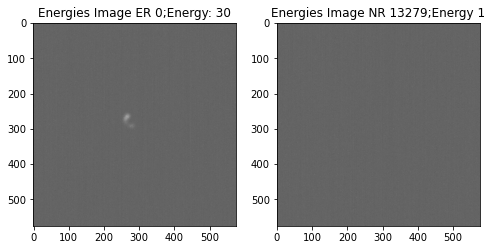

In [188]:
#Plot of an expl when there are patterns of ionization charge on the picture

for i in range(len(r)):
    if cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_ER, r.filename[i])) is not None:
        if cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_ER, r.filename[i])).max() > 0:
            break
for j in range(len(r)):
    if cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_NR, r.filename[i])) is not None:
        if cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_NR, r.filename[i])).max() > 0:
            break
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_ER, r.filename[i])))
plt.title('Energies Image ER '+ str(i) + ";Energy: " + str(r.Energy[i]))

plt.subplot(1,2,2)
plt.imshow(cv2.imread(os.path.join(conf.DATA_DIR_TRAIN_NR, r.filename[j])))
plt.title('Energies Image NR '+ str(j)+ ";Energy " + str(r.Energy[j]))